In [6]:
import pandas as pd
import numpy as np

In [7]:
feature_set_df = pd.read_parquet("https://raw.githubusercontent.com/erikhall6373/big_data_bowl_2025/refs/heads/main/data/updated_separation_yardage_feature_data.parquet")

In [8]:
#week1df = pd.read_parquet("https://raw.githubusercontent.com/erikhall6373/big_data_bowl_2025/refs/heads/main/data/tracking_week_1.parquet")

In [9]:
feature_set_df.query("gameId==2022102302").query("playId==2261").columns#.query("event=='three_secs_post_snap'")

Index(['gameId', 'playId', 'event', 'frameId', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playNullifiedByPenalty', 'offenseFormation',
       'receiverAlignment', 'passResult', 'playAction', 'timeToThrow', 'nflId',
       'teamAbbr', 'inMotionAtBallSnap', 'shiftSinceLineset',
       'motionSinceLineset', 'wasRunningRoute', 'routeRan', 'defender_nflId',
       'separation_yardage', 'receiver_x', 'receiver_y', 'receiver_s',
       'receiver_dir', 'defender_x', 'defender_y', 'defender_s',
       'defender_dir', 'cumulative_motion_distance'],
      dtype='object')

In [10]:
feature_set_df = feature_set_df.drop_duplicates()

In [11]:
#Net Velocity Between WR and DB
feature_set_df['netvelocity_x']=(feature_set_df['receiver_s']*np.cos(feature_set_df['receiver_dir']))-(feature_set_df['defender_s']*np.cos(feature_set_df['defender_dir']))
feature_set_df['netvelocity_y']=(feature_set_df['receiver_s']*np.sin(feature_set_df['receiver_dir']))-(feature_set_df['defender_s']*np.sin(feature_set_df['defender_dir']))
feature_set_df['nettheta']=np.arctan(feature_set_df['netvelocity_y']/feature_set_df['netvelocity_x'])

#X and Y Difference between Receiver and Defender
feature_set_df['netdist_x']=abs(feature_set_df['receiver_x']-feature_set_df['defender_x'])
feature_set_df['netdist_y']=abs(feature_set_df['receiver_y']-feature_set_df['defender_y'])


In [12]:
#Create 3 Key Moments: Line Set, Ball Snap, Pass/Sack

setmoment = feature_set_df[feature_set_df['event']=='line_set']
snapmoment = feature_set_df[feature_set_df['event']=='ball_snap']
passmoment = feature_set_df[feature_set_df['event'].isin(['pass_forward','qb_sack','three_secs_post_snap'])]

#feature_set_df['event'].unique()

In [13]:
#Clean the passmoment dataframe
passmoment['game_play']=passmoment['gameId'].astype(str)+passmoment['playId'].astype(str)
passmoment['minframe']=passmoment.groupby(passmoment['game_play'])['frameId'].transform('min')

<ipython-input-13-eecb7c59a4e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passmoment['game_play']=passmoment['gameId'].astype(str)+passmoment['playId'].astype(str)
<ipython-input-13-eecb7c59a4e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passmoment['minframe']=passmoment.groupby(passmoment['game_play'])['frameId'].transform('min')


In [14]:
passmoment = passmoment[passmoment['frameId']==passmoment['minframe']]

In [15]:
#Combine the Key Moments

snapmoment = snapmoment[['gameId', 'playId', 'event','nflId','defender_nflId','possessionTeam',
             'down','yardsToGo','receiver_s',
       'receiver_dir','netdist_x','netdist_y', 'defender_s',
       'defender_dir', 'cumulative_motion_distance', 'netvelocity_x',
       'netvelocity_y', 'nettheta',
            "receiverAlignment", "playAction", "motionSinceLineset", "shiftSinceLineset", "inMotionAtBallSnap",'separation_yardage','routeRan']]
passmoment = passmoment[['gameId', 'playId', 'event','nflId','defender_nflId','separation_yardage']]

#SOMETHING WEIRD IS GOING ON WITH DUPLICATES HERE*****
combineddf = pd.merge(snapmoment,passmoment,on=['gameId', 'playId','nflId','defender_nflId'],how='left',suffixes=('','_pass')).drop_duplicates(subset=['gameId','playId','nflId','defender_nflId'])




In [16]:
combineddf.columns

Index(['gameId', 'playId', 'event', 'nflId', 'defender_nflId',
       'possessionTeam', 'down', 'yardsToGo', 'receiver_s', 'receiver_dir',
       'netdist_x', 'netdist_y', 'defender_s', 'defender_dir',
       'cumulative_motion_distance', 'netvelocity_x', 'netvelocity_y',
       'nettheta', 'receiverAlignment', 'playAction', 'motionSinceLineset',
       'shiftSinceLineset', 'inMotionAtBallSnap', 'separation_yardage',
       'routeRan', 'event_pass', 'separation_yardage_pass'],
      dtype='object')

In [17]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [18]:
#Start Prepping for Modeling!!!!!!!!

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error




In [19]:
#Build 2 Models: One for Motion Plays and One for Non-Motion Plays
X= combineddf.fillna(0).dropna(subset=['down',
       'yardsToGo', 'receiver_s', 'receiver_dir', 'netdist_x', 'netdist_y',
       'defender_s', 'defender_dir',
       'netvelocity_x', 'netvelocity_y', 'nettheta', 'receiverAlignment',
       'playAction', 'motionSinceLineset', 'shiftSinceLineset',
       'inMotionAtBallSnap', 'separation_yardage','routeRan']+['separation_yardage_pass'])[['down',
       'yardsToGo', 'receiver_s', 'receiver_dir', 'netdist_x', 'netdist_y',
       'defender_s', 'defender_dir',
       'netvelocity_x', 'netvelocity_y', 'nettheta', 'receiverAlignment',
       'playAction', 'motionSinceLineset', 'shiftSinceLineset',
       'inMotionAtBallSnap', 'separation_yardage','routeRan']]
y= combineddf.fillna(0).dropna(subset=list(X.columns)+['separation_yardage_pass'])['separation_yardage_pass']

cat_features = ['down','receiverAlignment','playAction','motionSinceLineset','shiftSinceLineset','inMotionAtBallSnap','routeRan']

#Define Categorical Variables

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42,stratify=X['motionSinceLineset'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

#Initialize Model
motion_model = CatBoostRegressor(iterations=100,cat_features=cat_features,loss_function='RMSE')

#Train the Model
motion_model.fit(X_train,y_train,eval_set=(X_test,y_test),verbose=10)



Learning rate set to 0.351866
0:	learn: 3.2535622	test: 3.2930860	best: 3.2930860 (0)	total: 79.8ms	remaining: 7.9s
10:	learn: 2.4733273	test: 2.5155598	best: 2.5155598 (10)	total: 392ms	remaining: 3.17s
20:	learn: 2.4202246	test: 2.4764173	best: 2.4764173 (20)	total: 802ms	remaining: 3.02s
30:	learn: 2.3756616	test: 2.4555407	best: 2.4555407 (30)	total: 1.23s	remaining: 2.73s
40:	learn: 2.3354000	test: 2.4359387	best: 2.4356626 (39)	total: 1.58s	remaining: 2.28s
50:	learn: 2.3068904	test: 2.4290004	best: 2.4279729 (45)	total: 1.9s	remaining: 1.83s
60:	learn: 2.2829158	test: 2.4271181	best: 2.4271181 (60)	total: 2.42s	remaining: 1.55s
70:	learn: 2.2594498	test: 2.4231781	best: 2.4231781 (70)	total: 2.76s	remaining: 1.13s
80:	learn: 2.2390955	test: 2.4213065	best: 2.4213007 (77)	total: 3.13s	remaining: 734ms
90:	learn: 2.2150590	test: 2.4101101	best: 2.4101101 (90)	total: 3.57s	remaining: 353ms
99:	learn: 2.1950674	test: 2.4066914	best: 2.4066914 (99)	total: 3.86s	remaining: 0us

bestTe

In [20]:
Y_train = motion_model.predict(X_train)
Y_test = motion_model.predict(X_test)

print("Training RMSE: ", np.sqrt(mean_squared_error(Y_train, y_train)))
print("Validation RMSE: ", np.sqrt(mean_squared_error(Y_test, y_test)))

Training RMSE:  2.1972853966494053
Validation RMSE:  2.4066913990960703


In [21]:
feature_importance = motion_model.get_feature_importance()
feature_names = X_train.columns
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: down, Importance: 1.31
Feature: yardsToGo, Importance: 2.53
Feature: receiver_s, Importance: 3.27
Feature: receiver_dir, Importance: 3.37
Feature: netdist_x, Importance: 6.11
Feature: netdist_y, Importance: 9.72
Feature: defender_s, Importance: 2.92
Feature: defender_dir, Importance: 2.75
Feature: netvelocity_x, Importance: 1.38
Feature: netvelocity_y, Importance: 1.80
Feature: nettheta, Importance: 1.45
Feature: receiverAlignment, Importance: 0.06
Feature: playAction, Importance: 1.18
Feature: motionSinceLineset, Importance: 0.32
Feature: shiftSinceLineset, Importance: 0.02
Feature: inMotionAtBallSnap, Importance: 0.38
Feature: separation_yardage, Importance: 39.47
Feature: routeRan, Importance: 21.96


In [22]:
#Build 2 Models: One for Motion Plays and One for Non-Motion Plays
#X2= combineddf.query("motionSinceLineset==False").fillna(0).dropna(subset=['down',
#       'yardsToGo', 'receiver_s', 'receiver_dir', 'netdist_x', 'netdist_y',
#       'defender_s', 'defender_dir',
#       'netvelocity_x', 'netvelocity_y', 'nettheta', 'receiverAlignment',
#       'playAction', 'motionSinceLineset', 'shiftSinceLineset',
#       'inMotionAtBallSnap', 'separation_yardage','routeRan']+['separation_yardage_pass'])[['down',
#       'yardsToGo', 'receiver_s', 'receiver_dir', 'netdist_x', 'netdist_y',
#       'defender_s', 'defender_dir',
#       'netvelocity_x', 'netvelocity_y', 'nettheta', 'receiverAlignment',
##       'playAction', 'motionSinceLineset', 'shiftSinceLineset',
 #      'inMotionAtBallSnap', 'separation_yardage','routeRan']]
#y2= combineddf.query("motionSinceLineset==False").fillna(0).dropna(subset=list(X.columns)+['separation_yardage_pass'])['separation_yardage_pass']

#cat_features = ['down','receiverAlignment','playAction','motionSinceLineset','shiftSinceLineset','inMotionAtBallSnap','routeRan']

#Define Categorical Variables

#X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.2, random_state=42)

#Initialize Model
#nonmotion_model = CatBoostRegressor(iterations=100,cat_features=cat_features,loss_function='RMSE')

#Train the Model
#nonmotion_model.fit(X_train2,y_train2,eval_set=(X_test2,y_test2),verbose=10)


#Y_train2 = nonmotion_model.predict(X_train2)
#Y_test2 = nonmotion_model.predict(X_test2)

#print("Training RMSE: ", np.sqrt(mean_squared_error(Y_train2, y_train2)))
#print("Validation RMSE: ", np.sqrt(mean_squared_error(Y_test2, y_test2)))


In [23]:
#feature_importance = nonmotion_model.get_feature_importance()
#feature_names = X_train2.columns
#for name, importance in zip(feature_names, feature_importance):
#    print(f"Feature: {name}, Importance: {importance:.2f}")

In [24]:
#Let's see what happens with all the DATA!!!

#use setmoment to get the initial expected values for each play
#use combineddf to get motion-expected values and actual values for each play

setmoment['predictedSetSeparation']=motion_model.predict(setmoment.fillna(0)[X.columns])
combineddf['predictedMotionSeparation']=motion_model.predict(combineddf.fillna(0)[X.columns])

#setmoment[X.columns]


<ipython-input-24-9d1003def8c7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setmoment['predictedSetSeparation']=motion_model.predict(setmoment.fillna(0)[X.columns])


In [25]:
#separation_yardage_pass -> Separation at key moment
#predictedMotionSeparation -> Predicted value
#separation_yardage -> Separation at time of snap
evaluationdf = combineddf[['nflId','defender_nflId','separation_yardage','predictedMotionSeparation','separation_yardage_pass','possessionTeam']]\
.assign(postSnapSeparationAdded = lambda x: x['separation_yardage_pass']-x['predictedMotionSeparation'])\
.assign(percentRoutesWithAddedPostSnapSeparation = lambda x: x['postSnapSeparationAdded']>0)\
.groupby('nflId')[['predictedMotionSeparation','postSnapSeparationAdded','percentRoutesWithAddedPostSnapSeparation']].agg({'predictedMotionSeparation':'mean','postSnapSeparationAdded':'mean','percentRoutesWithAddedPostSnapSeparation':['mean','count']})\
#.sort_values('percent',ascending=False)


evaluationdf.columns = ['predictedMotionSeparation','postSnapSeparationAdded','percentRoutesWithAddedPostSnapSeparation','count']


evaluationdf.query("count>25").sort_values('postSnapSeparationAdded').reset_index()['count'].describe()#.to_csv('/content/drive/MyDrive/Big Data Bowl 2025/separationaddedteam.csv')

#combineddf[['nflId','defender_nflId','separation_yardage','predictedMotionSeparation','separation_yardage_pass']]\
#.assign(postSnapSeparationAdded = lambda x: x['separation_yardage_pass']-x['predictedMotionSeparation'])\
#.groupby('nflId')[['predictedMotionSeparation','postSnapSeparationAdded']].sum()\
#.sort_values('postSnapSeparationAdded',ascending=False)



,count
count,305.000000
mean,112.937705
std,72.575954
min,26.000000
25%,52.000000
50%,93.000000
75%,159.000000
max,300.000000


In [26]:
combineddf.columns


evaluationdf2 = combineddf.query("inMotionAtBallSnap==1")[['nflId','defender_nflId','separation_yardage','predictedMotionSeparation','separation_yardage_pass']]\
.assign(postSnapSeparationAdded = lambda x: x['separation_yardage_pass']-x['predictedMotionSeparation'])\
.assign(percentRoutesWithAddedPostSnapSeparation = lambda x: x['postSnapSeparationAdded']>0)\
.groupby('nflId')[['predictedMotionSeparation','postSnapSeparationAdded','percentRoutesWithAddedPostSnapSeparation']].agg({'predictedMotionSeparation':'mean','postSnapSeparationAdded':'mean','percentRoutesWithAddedPostSnapSeparation':['mean','count']})\
#.sort_values('percent',ascending=False)

display("Motion Plays")
evaluationdf2.columns = ['predictedMotionSeparation','postSnapSeparationAdded','percentRoutesWithAddedPostSnapSeparation','count']
evaluationdf2.query("count>5").sort_values('postSnapSeparationAdded')


'Motion Plays'

,predictedMotionSeparation,postSnapSeparationAdded,percentRoutesWithAddedPostSnapSeparation,count
nflId,,,,
54499.0,7.481650,-2.217355,0.166667,6
44835.0,5.213720,-2.143423,0.142857,7
52584.0,5.266538,-2.120738,0.142857,7
46071.0,6.076277,-1.847907,0.000000,8
48096.0,6.618653,-1.761577,0.166667,6
...,...,...,...,...
46830.0,6.562805,1.544684,0.625000,8
47791.0,4.805136,1.697466,0.428571,7
44995.0,6.975958,1.713067,0.727273,11


In [27]:
#Tell the Story:
#43.4% of routes exceed expectation
combineddf[['nflId','defender_nflId','separation_yardage','predictedMotionSeparation','separation_yardage_pass']]\
.assign(postSnapSeparationAdded = lambda x: x['separation_yardage_pass']-x['predictedMotionSeparation'])\
.assign(percentRoutesWithAddedPostSnapSeparation = lambda x: x['postSnapSeparationAdded']>0)\
['percentRoutesWithAddedPostSnapSeparation'].mean()

#43.7% exceed when in-motion; 44.2% exceed when not in-motion
combineddf.query("inMotionAtBallSnap==0")[['nflId','defender_nflId','separation_yardage','predictedMotionSeparation','separation_yardage_pass']]\
.assign(postSnapSeparationAdded = lambda x: x['separation_yardage_pass']-x['predictedMotionSeparation'])\
.assign(percentRoutesWithAddedPostSnapSeparation = lambda x: x['postSnapSeparationAdded']>0)\
['percentRoutesWithAddedPostSnapSeparation'].mean()

#(Median Routes per receiver is 51.5)
#34 players with a minimum of 50 routes have a 50%+ exceeds rate; 236 total receivers
#57 (18%) players with a minimum of 25 routes have a 50%+ exceeds rate; 312 total receivers
len(combineddf[['nflId','defender_nflId','separation_yardage','predictedMotionSeparation','separation_yardage_pass']]\
.assign(postSnapSeparationAdded = lambda x: x['separation_yardage_pass']-x['predictedMotionSeparation'])\
.assign(percentRoutesWithAddedPostSnapSeparation = lambda x: x['postSnapSeparationAdded']>0)\
.groupby('nflId')['percentRoutesWithAddedPostSnapSeparation'].agg(['mean','count']).reset_index().query("count>=25"))






312

In [28]:
allpredictions = pd.merge(setmoment[['gameId','playId','nflId','defender_nflId','predictedSetSeparation']],
combineddf[['gameId','playId','nflId','defender_nflId','motionSinceLineset','predictedMotionSeparation','separation_yardage_pass']],
         how='right',on=['gameId','playId','nflId','defender_nflId']).drop_duplicates(subset=['gameId','playId','nflId','defender_nflId'])

In [29]:
allpredictions[['predictedSetSeparation','predictedMotionSeparation','separation_yardage_pass']].describe()

,predictedSetSeparation,predictedMotionSeparation,separation_yardage_pass
count,35881.000000,36189.000000,36165.000000
mean,4.734554,4.552711,4.559379
std,2.979014,2.859028,3.727280
min,0.552407,0.076012,0.139284
25%,2.689968,2.602112,1.741522
50%,3.885750,3.801599,3.563664
75%,6.117327,5.929200,6.327377
max,35.245146,38.897969,43.011888


In [30]:
allpredictions['motionAddedSeparation']=allpredictions['predictedMotionSeparation']-allpredictions['predictedSetSeparation']
allpredictions['aboveAddedSeparation']=allpredictions['separation_yardage_pass']-allpredictions['predictedMotionSeparation']



In [31]:
allpredictions.query("motionSinceLineset==True")[['motionAddedSeparation','aboveAddedSeparation']].describe()

,motionAddedSeparation,aboveAddedSeparation
count,3129.000000,3147.000000
mean,-1.500063,0.039990
std,3.628152,2.434199
min,-26.137095,-8.908124
25%,-2.842227,-1.484846
50%,-0.899979,-0.280357
75%,0.353713,1.289447
max,15.683345,22.188108


In [32]:
#Why is motionAddedSeparation<0

setmoment[['motionSinceLineset','separation_yardage','netvelocity_x',
      'netvelocity_y', 'nettheta', 'netdist_x', 'netdist_y']]\
      .groupby('motionSinceLineset')['separation_yardage'].median()

,separation_yardage
motionSinceLineset,
False,8.234106
True,10.915003


In [33]:
combineddf.groupby('motionSinceLineset')['separation_yardage'].median()

,separation_yardage
motionSinceLineset,
False,8.113353
True,8.458280


In [34]:
receivercompare = allpredictions.query("motionSinceLineset==True").groupby('nflId')[['motionAddedSeparation','aboveAddedSeparation']].agg(['mean','median','count'])

receivercompare.columns=['MotionAdded_mean','MotionAdded_median','MotionAdded_count','ReceiverAdded_mean','ReceiverAdded_median','ReceiverAdded_count']

receivercompare= receivercompare.reset_index()

In [35]:
receivercompare.query("MotionAdded_count>10")\
.sort_values("MotionAdded_median",ascending=False)

,nflId,MotionAdded_mean,MotionAdded_median,MotionAdded_count,ReceiverAdded_mean,ReceiverAdded_median,ReceiverAdded_count
181,47839.0,0.626837,1.094425,25,0.000402,0.483714,25
176,47819.0,-0.718984,0.848753,16,0.225686,-0.704167,16
108,45052.0,0.549933,0.633283,12,1.674874,1.357906,12
281,53439.0,-1.134504,0.310701,12,-0.378565,-0.705168,12
182,47842.0,-1.144375,0.299379,20,0.352523,0.104578,20
...,...,...,...,...,...,...,...
79,44817.0,-4.180978,-3.021011,13,-0.150276,-0.364614,13
153,46277.0,-2.671207,-3.193352,13,0.012134,-0.157498,13
57,43324.0,-3.117380,-3.411132,19,0.074512,-0.701301,19
20,41246.0,-3.060147,-3.500025,19,0.241981,-0.152184,19


In [36]:
allpredictions\
.query("gameId==2022100204").query("playId==1422")

,gameId,playId,nflId,defender_nflId,predictedSetSeparation,motionSinceLineset,predictedMotionSeparation,separation_yardage_pass,motionAddedSeparation,aboveAddedSeparation
14,2022100204,1422,43293.0,53592.0,7.295866,False,6.189671,8.711292,-1.106194,2.521620
15,2022100204,1422,45052.0,43313.0,2.895542,False,3.444953,2.971548,0.549411,-0.473405
16,2022100204,1422,46150.0,43373.0,1.680713,False,2.837018,3.078782,1.156305,0.241765
17,2022100204,1422,46206.0,53503.0,5.563560,True,5.678482,9.904474,0.114921,4.225992
18,2022100204,1422,52425.0,42488.0,2.138278,False,4.691237,12.895457,2.552960,8.204219


In [37]:
combineddf.query("gameId==2022100204").query("playId==1422")

,gameId,playId,event,nflId,defender_nflId,possessionTeam,down,yardsToGo,receiver_s,receiver_dir,...,receiverAlignment,playAction,motionSinceLineset,shiftSinceLineset,inMotionAtBallSnap,separation_yardage,routeRan,event_pass,separation_yardage_pass,predictedMotionSeparation
14,2022100204,1422,ball_snap,43293.0,53592.0,DAL,3,8,0.00,274.45,...,3x1,False,False,False,False,8.306558,FLAT,three_secs_post_snap,8.711292,6.189671
15,2022100204,1422,ball_snap,45052.0,43313.0,DAL,3,8,0.01,94.32,...,3x1,False,False,False,False,8.893784,HITCH,three_secs_post_snap,2.971548,3.444953
16,2022100204,1422,ball_snap,46150.0,43373.0,DAL,3,8,0.00,79.69,...,3x1,False,False,False,False,4.909175,HITCH,three_secs_post_snap,3.078782,2.837018
17,2022100204,1422,ball_snap,46206.0,53503.0,DAL,3,8,1.34,158.09,...,3x1,False,True,False,True,7.966461,FLAT,three_secs_post_snap,9.904474,5.678482
18,2022100204,1422,ball_snap,52425.0,42488.0,DAL,3,8,0.11,104.86,...,3x1,False,False,False,False,10.682958,HITCH,three_secs_post_snap,12.895457,4.691237


In [39]:
allplayers = pd.read_parquet("https://raw.githubusercontent.com/erikhall6373/big_data_bowl_2025/refs/heads/main/data/players.parquet")



In [40]:
(combineddf[['nflId','defender_nflId','separation_yardage','predictedMotionSeparation','separation_yardage_pass']]\
.assign(postSnapSeparationAdded = lambda x: x['separation_yardage_pass']-x['predictedMotionSeparation'])\
.assign(percentRoutesWithAddedPostSnapSeparation = lambda x: x['postSnapSeparationAdded']>0)\
.groupby('nflId')['percentRoutesWithAddedPostSnapSeparation'].agg(['mean','count']).reset_index().query("count>=25"))


,nflId,mean,count
1,37077.0,0.392157,153
2,37079.0,0.483871,62
3,37101.0,0.488372,43
6,37139.0,0.366337,101
7,38696.0,0.500000,184
...,...,...,...
444,54723.0,0.440000,25
449,54846.0,0.422222,45
451,54905.0,0.509434,53
463,55157.0,0.446154,65


In [45]:
wrdf = pd.merge(
    evaluationdf.query("count>25").sort_values('postSnapSeparationAdded').reset_index(),
    allplayers,how='left',on='nflId'
).query("position.isin(['TE','WR'])")

In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#wrdf.plot(x='predictedMotionSeparation',y='postSnapSeparationAdded',kind='scatter')

[]

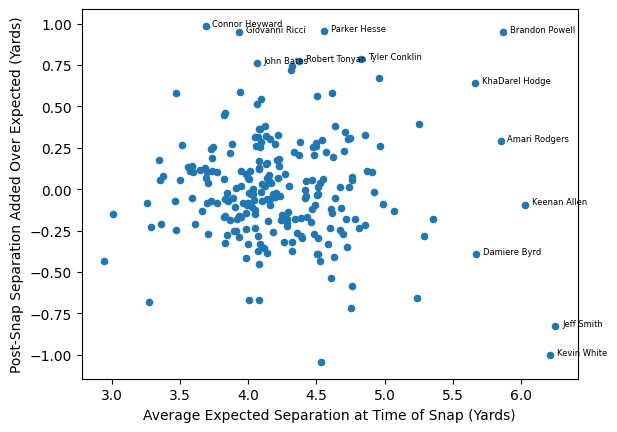

In [80]:
fig, ax = plt.subplots()

wrdf.plot(x='predictedMotionSeparation',y='postSnapSeparationAdded',kind='scatter',ax=ax)


for _,i in wrdf.query("(predictedMotionSeparation>5.5)|(postSnapSeparationAdded>0.75)").iterrows():
  ax.annotate(i['displayName'],(i['predictedMotionSeparation']+.05,i['postSnapSeparationAdded']),size=6)


ax.set_xlabel("Average Expected Separation at Time of Snap (Yards)")
ax.set_ylabel("Post-Snap Separation Added Over Expected (Yards)")

plt.plot()

[]

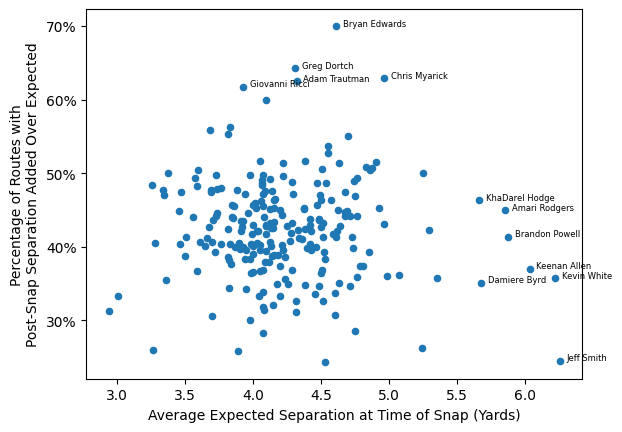

In [81]:
#wrdf.query("(predictedMotionSeparation>5.5)|(postSnapSeparationAdded>0.75)")

fig, ax = plt.subplots()

wrdf.plot(x='predictedMotionSeparation',y='percentRoutesWithAddedPostSnapSeparation',kind='scatter',ax=ax)


for _,i in wrdf.query("(predictedMotionSeparation>5.5)|(percentRoutesWithAddedPostSnapSeparation>0.6)").iterrows():
  ax.annotate(i['displayName'],(i['predictedMotionSeparation']+.05,i['percentRoutesWithAddedPostSnapSeparation']),size=6)

ax.set_xlabel("Average Expected Separation at Time of Snap (Yards)")
ax.set_ylabel("Percentage of Routes with\nPost-Snap Separation Added Over Expected")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))


plt.plot()


[]

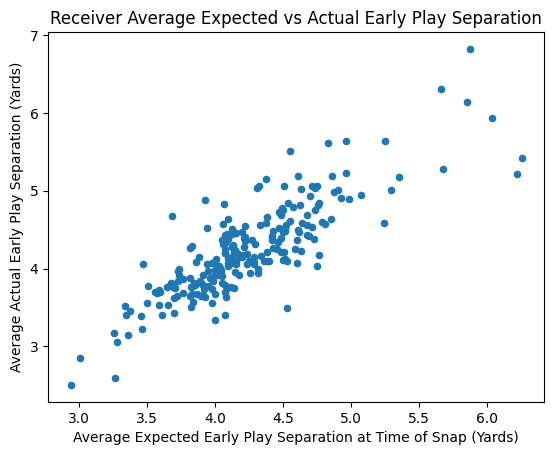

In [110]:



fig, ax = plt.subplots()

wrdf.assign(earlyPlaySeparation = lambda x: x['predictedMotionSeparation']+x['postSnapSeparationAdded'])\
.plot(x='predictedMotionSeparation',y='earlyPlaySeparation',kind='scatter',ax=ax)

#for _,i in wrdf.query("(predictedMotionSeparation>5.5)|(percentRoutesWithAddedPostSnapSeparation>0.6)").iterrows():
#  ax.annotate(i['displayName'],(i['predictedMotionSeparation']+.05,i['percentRoutesWithAddedPostSnapSeparation']),size=6)

ax.set_xlabel("Average Expected Early Play Separation at Time of Snap (Yards)")
ax.set_ylabel("Average Actual Early Play Separation (Yards)")

plt.title("Receiver Average Expected vs Actual Early Play Separation")


plt.plot()

[]

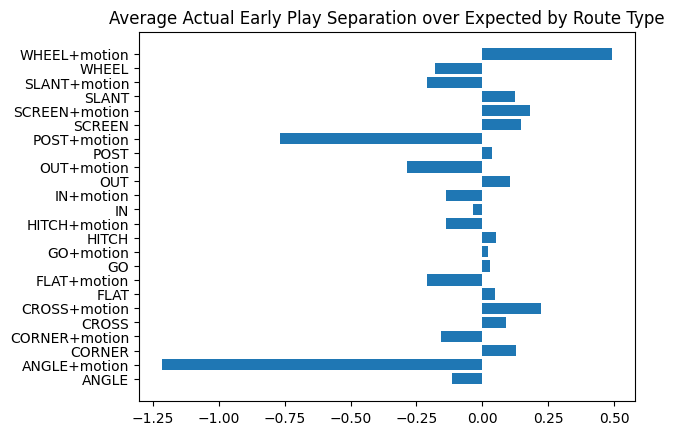

In [109]:
#combineddf.columns#.head(20)

#combineddf.plot(x='receiver_s',y='predictedMotionSeparation',kind='scatter')

bardata2 = combineddf.assign(postSnapSeparationAdded = lambda x: x['separation_yardage_pass']-x['predictedMotionSeparation'])\
.assign(percentRoutesWithAddedPostSnapSeparation = lambda x: x['postSnapSeparationAdded']>0).groupby(['routeRan','inMotionAtBallSnap'])['postSnapSeparationAdded'].mean().reset_index()\
.assign(PlayMotion = lambda x: x['routeRan']+np.where(x['inMotionAtBallSnap']==True,'+motion',''))


fig, ax = plt.subplots()
ax.barh(bardata2['PlayMotion'],bardata2['postSnapSeparationAdded'])
plt.title("Average Actual Early Play Separation over Expected by Route Type")
plt.plot()


In [106]:
combineddf.columns

Index(['gameId', 'playId', 'event', 'nflId', 'defender_nflId',
       'possessionTeam', 'down', 'yardsToGo', 'receiver_s', 'receiver_dir',
       'netdist_x', 'netdist_y', 'defender_s', 'defender_dir',
       'cumulative_motion_distance', 'netvelocity_x', 'netvelocity_y',
       'nettheta', 'receiverAlignment', 'playAction', 'motionSinceLineset',
       'shiftSinceLineset', 'inMotionAtBallSnap', 'separation_yardage',
       'routeRan', 'event_pass', 'separation_yardage_pass',
       'predictedMotionSeparation'],
      dtype='object')

[]

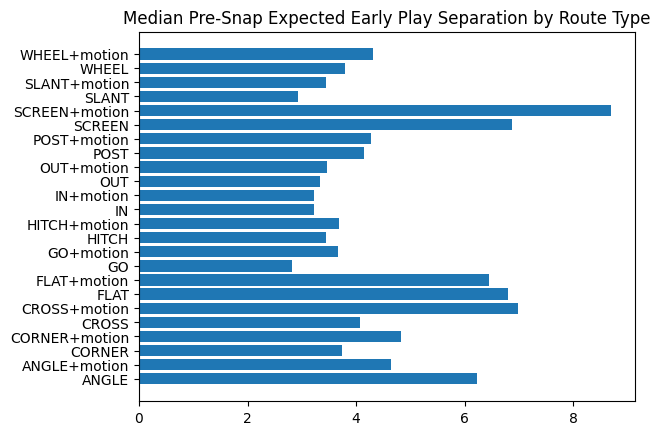

In [104]:
#combineddf.columns#.head(20)

#combineddf.plot(x='receiver_s',y='predictedMotionSeparation',kind='scatter')

bardata = combineddf.groupby(['routeRan','inMotionAtBallSnap'])['predictedMotionSeparation'].median().reset_index()\
.assign(PlayMotion = lambda x: x['routeRan']+np.where(x['inMotionAtBallSnap']==True,'+motion',''))


fig, ax = plt.subplots()
ax.barh(bardata['PlayMotion'],bardata['predictedMotionSeparation'])
plt.title("Median Pre-Snap Expected Early Play Separation by Route Type")
plt.plot()


[]

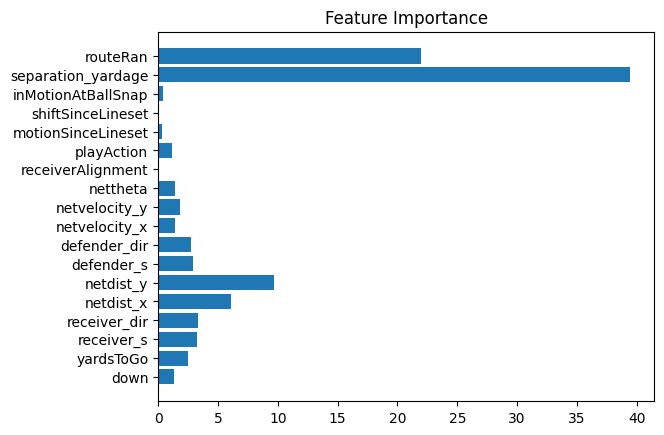

In [112]:
feature_importance = motion_model.get_feature_importance()
feature_names = X_train.columns
#for name, importance in zip(feature_names, feature_importance):
#    print(f"Feature: {name}, Importance: {importance:.2f}")

fig, ax = plt.subplots()
ax.barh(feature_names,feature_importance)
plt.title("Feature Importance")
plt.plot()
